In [1]:
#importing necessary libraries
import seaborn as sns
color_pal = sns.color_palette()
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd 
import numpy as np
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from datetime import datetime
import datetime
from sklearn.model_selection import TimeSeriesSplit
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.graph_objects as go
import scipy.stats as stats

In [2]:
df = pd.read_csv("QB2018.csv").dropna()
for x in range(2019,2023):
    df = pd.concat([df,pd.read_csv(f"QB{x}.csv").dropna()], axis=0)
df = df[df["FPTS/G"] > 10]
df['YDS'] = df['YDS'].str.replace(',', '').astype(float)
df = df.reset_index()

In [5]:
df.corr()

,index,Rank,CMP,ATT,PCT,YDS,Y/A,TD,INT,SACKS,ATT.1,TD.1,FL,G,FPTS,FPTS/G
index,1.000000,1.000000,-0.909010,-0.904540,-0.425201,-0.931206,-0.337838,-0.905430,-0.613179,-0.699510,-0.634638,-0.491303,-0.431178,-0.924494,-0.977259,-0.692604
Rank,1.000000,1.000000,-0.909010,-0.904540,-0.425201,-0.931206,-0.337838,-0.905430,-0.613179,-0.699510,-0.634638,-0.491303,-0.431178,-0.924494,-0.977259,-0.692604
CMP,-0.909010,-0.909010,1.000000,0.993862,0.479877,0.985151,0.219903,0.874889,0.688052,0.705854,0.409323,0.289263,0.519405,0.946342,0.909911,0.539962
ATT,-0.904540,-0.904540,0.993862,1.000000,0.397869,0.979807,0.172849,0.855691,0.720521,0.724196,0.421612,0.299076,0.530257,0.953907,0.902270,0.515285
PCT,-0.425201,-0.425201,0.479877,0.397869,1.000000,0.468839,0.505793,0.493066,0.124370,0.209857,0.119986,0.068167,0.196523,0.390072,0.443766,0.376044
YDS,-0.931206,-0.931206,0.985151,0.979807,0.468839,1.000000,0.332304,0.908160,0.695807,0.703867,0.419302,0.297255,0.495994,0.943380,0.934473,0.592330
Y/A,-0.337838,-0.337838,0.219903,0.172849,0.505793,0.332304,1.000000,0.424123,0.080081,0.106690,0.103228,0.060989,0.026033,0.212365,0.354563,0.477854
TD,-0.905430,-0.905430,0.874889,0.855691,0.493066,0.908160,0.424123,1.000000,0.544510,0.532687,0.404827,0.255964,0.366377,0.828800,0.932966,0.720719
INT,-0.613179,-0.613179,0.688052,0.720521,0.124370,0.695807,0.080081,0.544510,1.000000,0.617724,0.334173,0.211005,0.390911,0.704912,0.598560,0.255393
SACKS,-0.699510,-0.699510,0.705854,0.724196,0.209857,0.703867,0.106690,0.532687,0.617724,1.000000,0.513742,0.348664,0.552031,0.785800,0.666370,0.281136


In [6]:

tss = TimeSeriesSplit(n_splits=5, test_size=20, gap=1)
df = df.sort_index()

fold = 0
preds = []
tests = []
scores = []
dates = []

for train_idx, val_idx in tss.split(df):
    
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train = train
    test = test
    
    FEATURES = ['CMP', "ATT", 'TD', 'ATT.1', 'YDS', 'TD.1']
    TARGET = 'FPTS/G'

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    dates.append(test["Player"])

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    tests.append(y_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:17.07061	validation_1-rmse:18.22290
[100]	validation_0-rmse:6.79037	validation_1-rmse:7.96483
[200]	validation_0-rmse:3.13668	validation_1-rmse:4.48409
[300]	validation_0-rmse:1.89023	validation_1-rmse:3.68401
[400]	validation_0-rmse:1.44895	validation_1-rmse:3.60363
[439]	validation_0-rmse:1.34836	validation_1-rmse:3.60963
[0]	validation_0-rmse:17.22602	validation_1-rmse:14.40770
[100]	validation_0-rmse:6.88794	validation_1-rmse:4.96808
[200]	validation_0-rmse:3.27150	validation_1-rmse:2.35360
[300]	validation_0-rmse:2.11266	validation_1-rmse:2.18889
[305]	validation_0-rmse:2.07999	validation_1-rmse:2.19697
[0]	validation_0-rmse:16.88131	validation_1-rmse:16.20305
[100]	validation_0-rmse:6.74809	validation_1-rmse:6.82924
[200]	validation_0-rmse:3.19593	validation_1-rmse:3.52967
[300]	validation_0-rmse:2.04755	validation_1-rmse:2.67698
[392]	validation_0-rmse:1.66234	validation_1-rmse:2.68559
[0]	validation_0-rmse:16.79948	validation_1-rmse:15.44404
[100]	validati

In [8]:
new = pd.read_csv("QB2023.csv").dropna()
new['YDS'] = new['YDS'].str.replace(',', '').astype(float)
new['Prediction'] = reg.predict(new[FEATURES])
new.to_csv("QB-Projections.csv")

% Error Statistics:
count    100.000000
mean      11.546841
std       10.083027
min        0.262793
25%        3.322100
50%        9.768547
75%       17.500423
max       51.944718
Name: % Error, dtype: float64


<AxesSubplot:xlabel='% Error'>

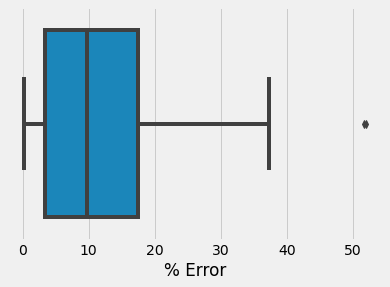

In [9]:
#making csv tracking predictions for each hour and actual results
analysis = pd.DataFrame({'Player': np.concatenate([dates[0], dates[1], dates[2], dates[3], dates[4]]), 'Prediction': np.concatenate([preds[0], preds[1], preds[2], preds[3], preds[4]]), 'Actual': np.concatenate([tests[0].values, tests[1].values, tests[2].values, tests[3].values, tests[4].values])})
analysis["% Error"] = ((analysis["Prediction"]-analysis["Actual"])/analysis["Actual"]).abs()*100
analysis.to_csv('QB-Full_Results.csv')

print("% Error Statistics:")

#printing error metrics, box-plot
print(analysis["% Error"].describe())
sns.boxplot(x=analysis["% Error"])
